In [1]:
from fastai.vision import *
from pathlib import Path

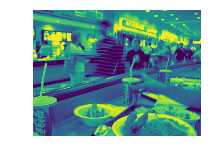

In [8]:
#il = ImageList.from_folder("data/train/train_0/", convert_mode='L')
il = ImageList.from_folder("data/fulltrain/", convert_mode='L')
il.items[0]
il[0].show()

In [35]:
bboxes = pd.read_csv('data/bboxes/test-annotations-bbox.csv')
class_names = pd.read_csv("data/class-descriptions-boxable.csv", header=None, names=["LabelName", "Class"])
labels = bboxes.merge(class_names, on="LabelName")
print(len(bboxes))
print(len(labels))
print(len(il))
labels.head()

937327
937327
1743042


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Class
0,000026e7ee790996,xclick,/m/07j7r,1,0.071875,0.145313,0.206250,0.391667,0,1,1,0,0,Tree
1,000026e7ee790996,xclick,/m/07j7r,1,0.439063,0.571875,0.264583,0.435417,0,1,1,0,0,Tree
2,000026e7ee790996,xclick,/m/07j7r,1,0.668750,1.000000,0.000000,0.552083,0,1,1,0,0,Tree
3,0002ab0af02e4a77,xclick,/m/07j7r,1,0.000000,1.000000,0.083032,0.397112,0,0,1,0,0,Tree
4,0003d84e0165d630,xclick,/m/07j7r,1,0.000000,0.998437,0.000000,0.247917,1,1,1,0,0,Tree


In [31]:
len(labels)

937327

In [21]:
# train_images[1], train_lbl_bbox[1]
# should output:
# ('000017.jpg', [[[61, 184, 199, 279], [77, 89, 336, 403]], ['person', 'horse']])

NameError: name 'hallo' is not defined

In [20]:
#idb=ImageDataBunch.from_folder("data/fulltrain/", ignore_empty=True)

In [15]:
il.get_label_cls(labels.loc[:, ["XMin", "XMax", "YMin", "YMax"]].values.tolist())

fastai.data_block.MultiCategoryList

In [ ]:
images, lbl_bbox = train_images+val_images,train_lbl_bbox+val_lbl_bbox
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'train')
    src = src.split_by_files(val_images)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)


In [5]:
# retain only labels for pictures in train_0/

In [6]:
ids = ['0' + path.stem for path in il.items]
labels.filter(items=ids, axis='ImageID')
#labels['ImageID'].isin([ids])
#labels['ImageID'].contains([ids])

ValueError: No axis named ImageID for object type <class 'pandas.core.frame.DataFrame'>

In [ ]:
labels.shape

In [ ]:
labels = bboxes.loc[:, "LabelName"]
print(labels[:5])
bboxes = bboxes.loc[:, ["XMin", "XMax", "YMin", "YMax"]].values.tolist()
print(bboxes[:5])

In [ ]:
#labels = pd.read_csv("data/labels/train-annotations-human-imagelabels-boxable.csv")
#labels.head()
#print(len(labels.loc[:, "LabelName"]))

In [ ]:
il.items[0]
il[0].show()

In [ ]:
sd = il.split_by_rand_pct(0.2, seed=42)

In [ ]:
ll = sd.label_from_folder()
ll